# PyMC3

In [1]:
# Use the most recent version of GemPy, fetched from GitHub
import sys, os
sys.path.insert(1,'../../..') # Load before pip version is loaded

import time
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import theano as t
import theano.tensor as tt
from theano.compile.ops import as_op
import pymc as pm2
import pymc3 as pm3

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Documentwide variables and settings
t.config.compute_test_value = 'warn'
dtype='float64'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
geo_data = gp.read_pickle('geo_data_20180516.pickle')


In [19]:
#interp_data = gp.read_pickle('interp_data_20180516.pickle')

In [3]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=False)

In [21]:
geomodel = t.OpFromGraph(interp_data.interpolator.tg.input_parameters_list(),
                         interp_data.interpolator.tg.compute_geological_model(interp_data.geo_data_res.n_faults),
                         on_unused_input='ignore',
                         #allow_input_downcast=False,
                         profile=False
                        )

In [10]:
geo_data.grid.values

array([[  2.37200000e+05,   6.43420600e+06,  -2.09352930e+03],
       [  2.37200000e+05,   6.43420600e+06,  -2.06824902e+03],
       [  2.37200000e+05,   6.43420600e+06,  -2.04296851e+03],
       ..., 
       [  2.70800000e+05,   6.46879400e+06,  -1.05703149e+03],
       [  2.70800000e+05,   6.46879400e+06,  -1.03175098e+03],
       [  2.70800000e+05,   6.46879400e+06,  -1.00647058e+03]], dtype=float32)

In [22]:
input_sh = []
for i in interp_data.get_input_data():
    input_sh.append(t.shared(i))

In [25]:
geomodel(*input_sh)[0].eval()

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.162501289149077e-08 / 5.960464477539063e-08
  RuntimeWarning)


array([[  2.00001574,   2.00000906,   2.00000477, ...,   1.81942391,
          1.74109232,   1.64270926],
       [ 40.6298027 ,  40.63034821,  40.63088608, ...,  40.64405441,
         40.64452744,  40.64500427]], dtype=float32)

In [13]:
#lith_block, fault = gp.compute_model(interp_data)

../../../gempy/gempy_front.py:867: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


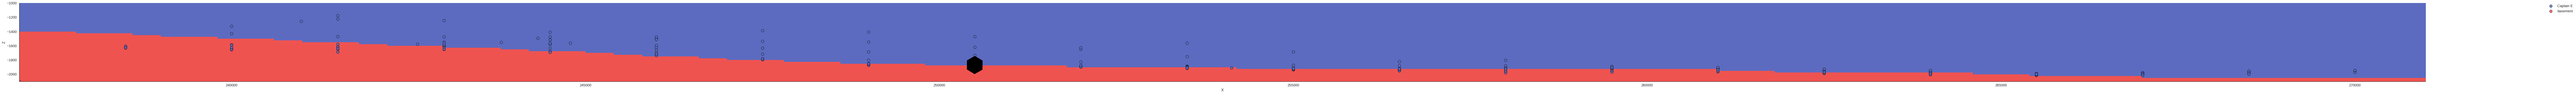

In [14]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], cell_number=25,  direction='y', plot_data=True)

In [16]:

ver, sim = gp.get_surfaces(interp_data, lith[1])


In [4]:
gp.plotting.plot_surfaces_3D(geo_data,ver, sim)

NameError: name 'ver' is not defined

In [5]:
group_ids = geo_data.interfaces["group_id"].dropna().unique()
print(group_ids)

['surface' 'wells']


In [4]:
# PyMC3

scale = interp_data.rescaling_factor
std = 20./scale

with pm3.Model() as model:
    # Stochastic Surface distribution
    surface_stoch = pm3.Normal('surface_stoch', mu=0, sd=1./std**2, testval=2, dtype=dtype)
   
    # Stochastic Wells distribution
    wells_stoch = pm3.Uniform('wells_stoch', -0.05, 0.05, dtype=dtype)
    

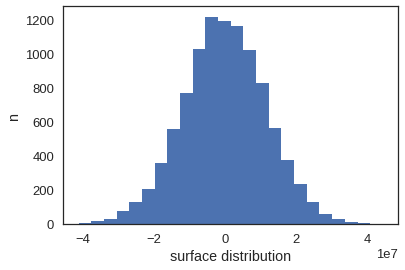

In [5]:
# sample from a distribtion and plot histogram
samples = [surface_stoch.random() for i in range(10000)]

plt.hist(samples, bins=24);
plt.xlabel("surface distribution")
plt.ylabel("n");

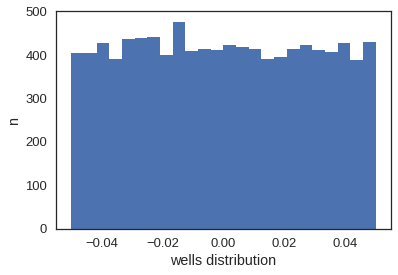

In [6]:
# sample from a distribtion and plot histogram
samples = [wells_stoch.random() for i in range(10000)]

plt.hist(samples, bins=24);
plt.xlabel("wells distribution")
plt.ylabel("n");

In [7]:
with model:
    t.config.compute_test_value = 'off'
    t.config.exception_verbosity = 'high'

# Convert python variable into theano.shared
    input_sh = []
    for i in interp_data.get_input_data():
        input_sh.append(t.shared(i))

        #t.tensor.as_tensor_variable

In [8]:
input_sh[5]

<TensorType(float32, matrix)>

In [9]:
# Initiate the Theano Operation
# Equates lith_block = gp.compute_model(interp_data)[0]? Likely!

with model:
    t.config.compute_test_value = 'ignore'
    geomodel = t.OpFromGraph(interp_data.interpolator.tg.input_parameters_list(),
                             interp_data.interpolator.tg.compute_geological_model(interp_data.geo_data_res.n_faults),
                             on_unused_input='ignore',
                             #allow_input_downcast=False,
                             profile=False
                            )
    gempy = pm3.Deterministic('gempy', geomodel(input_sh[0], # Position of the dips
                                            input_sh[1], # Angle of every dip
                                            input_sh[2], # Azimuth
                                            input_sh[3], # Polarity
                                            input_sh[4], # Reference points for every layer
                                            input_sh[5])[0],# Rest of the points of the layers
                         )
# compute_forward_gravity --> return [lith_matrix, fault_matrix, pfai, grav.sum(axis=1)]
# compute_geological_model --> return [lith_matrix[:, :-2 * self.len_points], self.fault_matrix[:, :-2 * self.len_points], pfai]  



# Adding the stochastic z-values
# We add the stochastic value to the correspondant array. rest array is
# a n_points*3 (XYZ) array. We only want to change Z in this case.
# Check for theano.tensor.inc_subtensor as substitute

#input_sh[4] = tt.set_subtensor(input_sh[4][:, 2],
#                              wells_stoch
#                             )

#input_sh[5] = tt.set_subtensor(input_sh[5][:, 2],
#                               wells_stoch)


/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.162501289149077e-08 / 5.960464477539063e-08
  RuntimeWarning)


In [ ]:
# Deterministic Model Function / Operation

with model:    
    # Stochastic Surface
   # t.config.exception_verbosity='low'
 
#with model:    
#        # Stochastic Surface
#        t.config.exception_verbosity='low'
#        gempy = pm3.Deterministic('gempy', geomodel(*input_sh))

In [ ]:
theano.config.compute_test_value = 'off'
with model:
    
    # stochastic model run
    iterations = 10
    step = pm3.Metropolis()
    backend = pm3.backends.HDF5(
        ('./database_3_' + time.strftime("%Y%m%d") + '.hdf5'),
        vars=gempy
    )                   

    traces = pm3.sample(iterations, step=step, trace=backend)

    #backend.close()

In [15]:
#@pm2.deterministic(trace=True)
#def input_data(value = 0, 
#               interface_z_modifier = interface_z_modifier,
#               geo_data_stoch_init = geo_data_init,
#               verbose = 0):
#    # First we extract from our original interp_data object the numerical data that is necessary for the interpolation.
#    # geo_data_stoch is a pandas Dataframe
#    # geo_data_stoch = gp.get_data(interp_data_original.geo_data_res, numeric=True)
#
#    geo_data_stoch = gp.get_data(geo_data_init, numeric=True)
#    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
#    for e, gID in enumerate(group_ids):
#        # First we obtain a boolean array with trues where the id coincide
#        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['group_id'] == gID
#        
#        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
#        geo_data_stoch.loc[sel, 'Z']  += np.array(interface_z_modifier[e])
#        
#    if verbose > 0:
#        print(geo_data_stoch)
#        
#    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
#    # We need to save the data as numpy arrays
#    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [16]:
# deterministic model parameter input_data

@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dscalar])
def input_data(surface_stoch,
               wells_stoch,
               geo_data_init = geo_data_init):
    
    # import data to be modified by model
    geo_data_stoch = gp.get_data(geo_data_init, numeric=True)
    
    # surface modification
    surface_bool = gp.get_data(interp_data.geo_data_res, verbosity=2)['group_id'] == 'surface'
    geo_data_stoch.loc[surface_bool, 'Z']  += np.array(surface_stoch)
    
    # wells modification    
    wells_bool = gp.get_data(interp_data.geo_data_res, verbosity=2)['group_id'] == 'wells'
    geo_data_stoch.loc[surface_bool, 'Z']  += np.array(wells_stoch)
    
       
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values

    
with model:
    #input_data = pm3.Deterministic('input_data')
    input_data = input_data(surface_stoch, wells_stoch)
    

In [41]:
# deterministic model parameter gempy_model

@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def gempy_model(input_data, verbose=True):
    
    # modify input data values accordingly??
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    try:
        # try to compute model
        lb = gp.compute_model(interp_data)[0]
        if True:
            gp.plotting.plot_section(interp_data.geo_data_res, lb[0], 0, direction='y', plot_data=True, ve=10)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_block), np.zeros_like(fault_block)
    

with model:
    #input_data = pm3.Deterministic('input_data')
    gempy_model = gempy_model(input_data)

ValueError: Cannot compute test value: input 0 (FromFunctionOp{input_data}.0) of Op FromFunctionOp{gempy_model}(FromFunctionOp{input_data}.0) missing default value.  
Backtrace when that variable is created:

  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-2d7b0005e423>", line 27, in <module>
    input_data = input_data(surface_stoch, wells_stoch)


In [42]:
#@pm2.deterministic(trace=False)
#def gempy_model(input_data=input_data, verbose=True):
#    
# #   # modify input data values accordingly
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    
#    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
#    interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z",  'dip', 'azimuth', 'polarity']] = input_data[1]
#    
#    try:
#        # try to compute model
#        lb = gp.compute_model(interp_data)[0]
#        if True:
#            gp.plotting.plot_section(interp_data.geo_data_res, lb[0], 0, direction='y', plot_data=True, ve=10)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#
#        return lb
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.zeros_like(lith_block), np.zeros_like(fault_block)

In [43]:
pm3.backends.HDF5?

# Posterior analysis

In [28]:
post = gp.posterior_analysis.Posterior('database_3_20180508.hdf5')

In [48]:
post.change_input_data(interp_data, 80)
lith_block = gp.compute_model(interp_data)[0]
lith_block
#gp.plotting.plot_section((interp_data.geo_data_res), (lith_block[0] * float), cell_number=25, direction='x', plot_data=True, ve=10)

/opt/conda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.694819383781578e-08 / 5.960464477539063e-08
  RuntimeWarning)


array([[ 1.       ,  1.       ,  1.       , ...,  1.0876002,  1.1005119,
         1.1147898],
       [40.299164 , 40.299294 , 40.299427 , ..., 40.319744 , 40.319942 ,
        40.320137 ]], dtype=float32)

/opt/conda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.385459734772667e-08 / 5.960464477539063e-08
  RuntimeWarning)


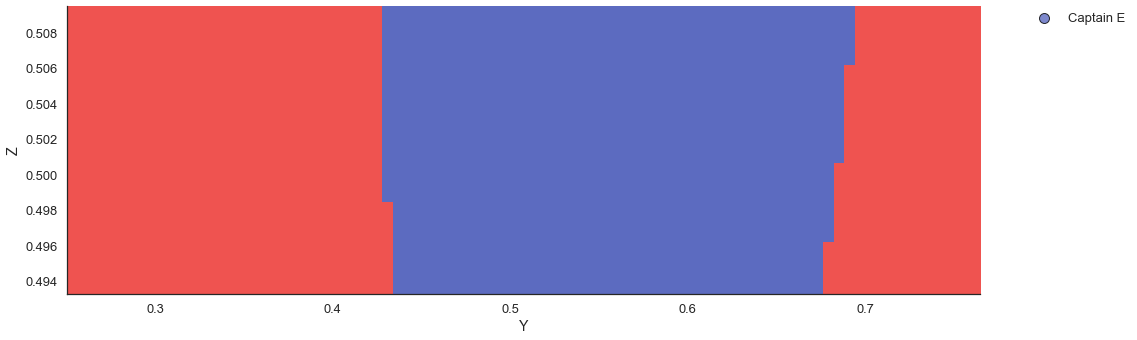

In [21]:
post.change_input_data(interp_data, 30)
lith_block = gp.compute_model(interp_data)[0]
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], cell_number=25, direction='x', plot_data=True, ve=10)

/opt/conda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.61125458425704e-08 / 5.960464477539063e-08
  RuntimeWarning)


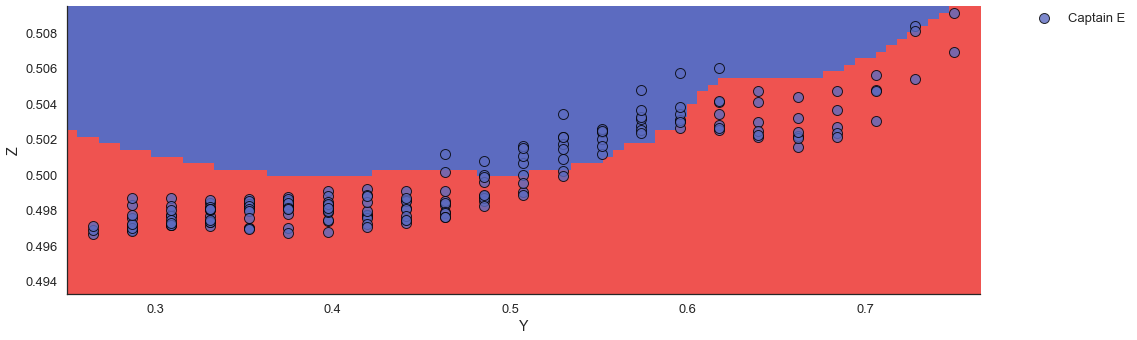

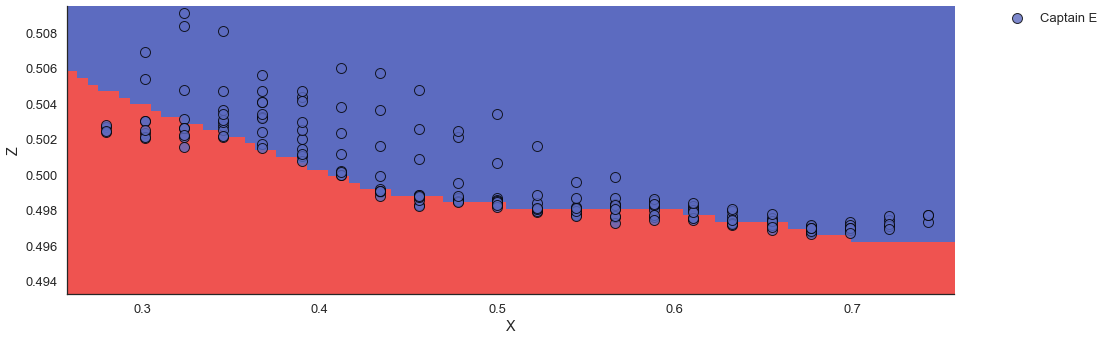

In [50]:
post.change_input_data(interp_data, 45)
lith_block = gp.compute_model(interp_data)[0]
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], cell_number=25, direction='x', plot_data=True, ve=10)
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], cell_number=25, direction='y', plot_data=True, ve=10)

In [23]:
r = tt.ivector
new_r = tt.set_subtensor(r[10:], 5)

TypeError: 'TensorType' object is not subscriptable